In [2]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 397.csv, 514.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=486.00, M2=924.00


In [3]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = set.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = set.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = set.addVars(I, T, S, vtype=GRB.BINARY, name="rho")
mu = set.addVars(I, T, S, vtype=GRB.BINARY, name="mu")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(ep[i, t, s] <= M1 * mu[i, t, s])
    set.addConstr(em[i, t, s] <= M1 * (1 - mu[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 32720 rows, 28976 columns and 84560 nonzeros
Model fingerprint: 0x223c3294
Variable types: 21296 continuous, 7680 integer (7680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 16197 rows and 12837 columns
Presolve time: 0.10s
Presolved: 16523 rows, 16139 columns, 46268 nonzeros
Variable types: 11359 continuous, 4780 integer (4780 binary)
Found heuristic solution: objective 516671.81161
Found heuristic solution: objective 547096.83064

Root relaxat

In [4]:
da_profit = sum(P_DA[t] * x[i, t].X for i in range(I) for t in range(T))
rt_profit = sum(P_RT[t, s] * ep[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * em[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost

print("[SETTLEMENT MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[SETTLEMENT MODEL]
DA Profit      = 213423.07
RT Profit      = 513020.71
Penalty Cost   = 4502.69
Total Profit   = 721941.09



[SETTLEMENT MODEL] Day-Ahead Commitment (sum over DERs):
TOTAL: 1339.00


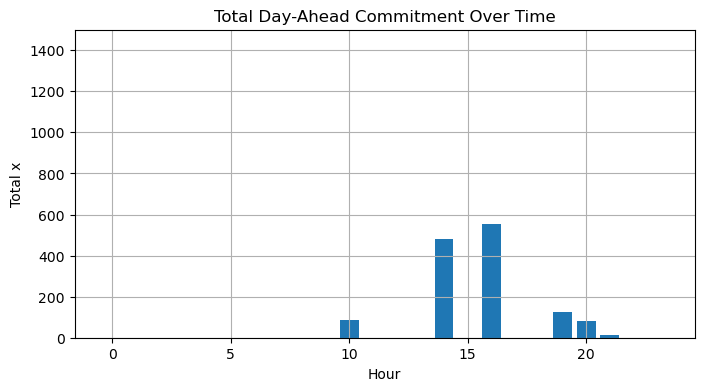

In [5]:
print("\n[SETTLEMENT MODEL] Day-Ahead Commitment (sum over DERs):")
total_only_commit = 0
for t in range(T):
    commit_t = sum(x[i, t].X for i in range(I))
    total_only_commit += commit_t
    # print(f"Time {t}: {commit_t:.2f}")
print(f"TOTAL: {total_only_commit:.2f}")

plt.figure(figsize=(8, 4))
plt.bar(range(T), x_vals.sum(axis=0))
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1500)
plt.grid(True)
plt.show()

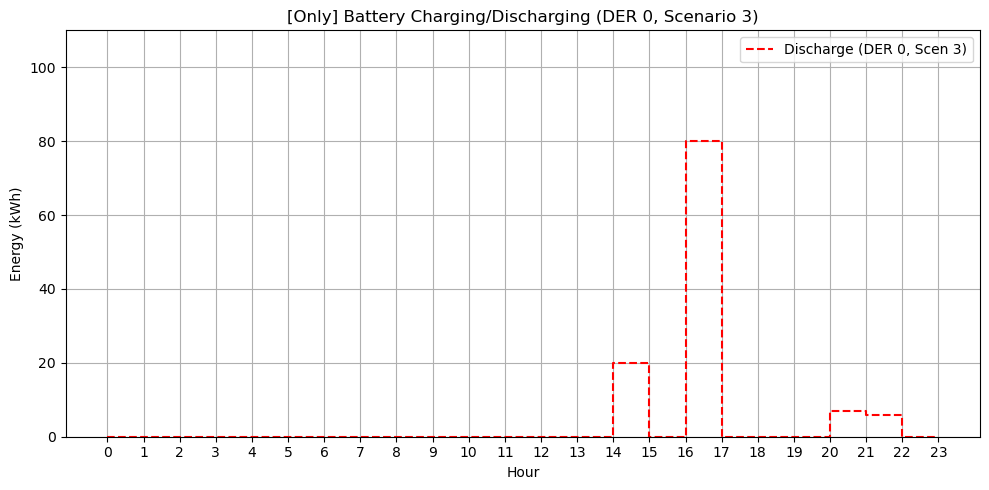

In [15]:
i=0
s=3
zc_single = zc_vals[i, :, s]  
zd_single = zd_vals[i, :, s]
z_single = z_vals[i, :, s]
hours = np.arange(len(zc_single))

plt.figure(figsize=(10, 5))
# plt.step(hours, zc_single, where='post', label=f"Charge (DER {i}, Scen {s})", color = 'green', linestyle = "--", linewidth = 1.5)
plt.step(hours, zd_single, where='post', label=f"Discharge (DER {i}, Scen {s})", linestyle = "--", color = 'red')
# plt.step(hours, z_single, where='post', label=f"SoC (DER {i}, Scen {s})", color='#00821E', linewidth=2)
plt.title(f"[Only] Battery Charging/Discharging (DER {i}, Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.ylim(0, K[i].max()+10)
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()